In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
from openpyxl import load_workbook

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


from parser.inflation import download_inflation, get_inflation_df
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_loans_volume_msp_df
from parser.dollar import get_dollar_df
from parser.broad_money_supply import get_broad_money_supply
from parser.bal import get_bal_df
from parser.cpi import get_cpi_df
from parser.bal_increase import get_bal_increase_df
from parser.gdp import get_gdp_on_2021_prices_dataframe
from parser.gdp import get_gdp_dataframe_wout_seasons

import dateparser
import matplotlib.dates as mdates

Получим данные по объему кредитов

In [2]:
df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024))
df

,msp_loans_volume,month_n,year,Отчетный период
0,452992.0,1,2019,Январь 2019 г.
1,482114.0,2,2019,Февраль 2019 г.
2,604402.0,3,2019,Март 2019 г.
3,686986.0,4,2019,Апрель 2019 г.
4,585284.0,5,2019,Май 2019 г.
...,...,...,...,...
59,1854476.0,12,2023,Декабрь 2023 г.
60,935130.0,1,2024,Январь 2024 г.
61,1216737.0,2,2024,Февраль 2024 г.
62,1524903.0,3,2024,Март 2024 г.


In [3]:
list_of_df = [] # список для хранения датафреймов с интересущими нас параметрами

Выгружаем данные по инфляции и ключевой ставке

In [4]:
start_date = datetime.datetime.strptime("01.01.2019", "%d.%m.%Y")
end_date = datetime.datetime.strptime("01.05.2024", "%d.%m.%Y")
download_inflation(start_date, end_date)
df_inflation = transform_df_to_format(get_inflation_df(start_date, end_date))
list_of_df.append(df_inflation)
df_inflation

C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,"Ключевая ставка, % годовых","Инфляция, % г/г",month_n,year,Отчетный период
0,7.75,5.00,1,2019,Январь 2019 г.
31,7.75,5.20,2,2019,Февраль 2019 г.
59,7.75,5.30,3,2019,Март 2019 г.
90,7.75,5.20,4,2019,Апрель 2019 г.
120,7.75,5.10,5,2019,Май 2019 г.
...,...,...,...,...,...
1795,16.00,7.42,12,2023,Декабрь 2023 г.
1826,16.00,7.44,1,2024,Январь 2024 г.
1857,16.00,7.69,2,2024,Февраль 2024 г.
1886,16.00,7.72,3,2024,Март 2024 г.


Выгружаем данные о курсе доллара

In [5]:
df_dollar = transform_df_to_format(get_dollar_df(start_date, end_date))
list_of_df.append(df_dollar)
df_dollar

C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,curs,month_n,year,Отчетный период
0,66.512544,1,2019,Январь 2019 г.
1,65.810525,2,2019,Февраль 2019 г.
2,65.092257,3,2019,Март 2019 г.
3,64.603105,4,2019,Апрель 2019 г.
4,64.818706,5,2019,Май 2019 г.
...,...,...,...,...
59,90.817186,12,2023,Декабрь 2023 г.
60,88.680288,1,2024,Январь 2024 г.
61,91.518255,2,2024,Февраль 2024 г.
62,91.731633,3,2024,Март 2024 г.


Выгружаем данные о широкой денежной массе 

In [6]:
broad_money_supply = transform_df_to_format(get_broad_money_supply(2019, 2024))
list_of_df.append(broad_money_supply)
broad_money_supply

,broad_money,month_n,year,Отчетный период
0,59779.4,1,2019,Январь 2019 г.
1,60469.3,2,2019,Февраль 2019 г.
2,60146.8,3,2019,Март 2019 г.
3,60481.3,4,2019,Апрель 2019 г.
4,60959.4,5,2019,Май 2019 г.
...,...,...,...,...
59,112483.1,12,2023,Декабрь 2023 г.
60,111777.1,1,2024,Январь 2024 г.
61,113844.5,2,2024,Февраль 2024 г.
62,114105.6,3,2024,Март 2024 г.


Выгружаем данные о счете текущих операций

In [7]:
bal_df = get_bal_df()
bal_df

File downloaded:bal_of_payments_standart.xlsx


C:\Users\Дарья\Documents\pydatan\проект\hub-act-frcst\parser\bal.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_daily = pd.concat([df_daily, df_quarter], ignore_index=True)


,data,значение
0,1994-01-01,1996.33
1,1994-01-02,1996.33
2,1994-01-03,1996.33
3,1994-01-04,1996.33
4,1994-01-05,1996.33
...,...,...
10952,2023-12-27,11499.87
10953,2023-12-28,11499.87
10954,2023-12-29,11499.87
10955,2023-12-30,11499.87


Выгружаем данные об ИПЦ

In [8]:
#cpi_df = get_cpi_df()
#cpi_df

Выгружаем жанные о ВВП

In [9]:
gdp_on_2021_prices_df = get_gdp_on_2021_prices_dataframe()
gdp_on_2021_prices_df = gdp_on_2021_prices_df[gdp_on_2021_prices_df['date'] >= start_date]
gdp_on_2021_prices_df = gdp_on_2021_prices_df[gdp_on_2021_prices_df['date'] < end_date]
gdp_on_2021_prices_df = gdp_on_2021_prices_df.drop('date', axis = 1)
gdp_on_2021_prices_df = gdp_on_2021_prices_df.reset_index(drop=True)
gdp_on_2021_prices_df = gdp_on_2021_prices_df.rename(columns={'gdp': 'gdp_on_2021_prices'})
gdp_on_2021_prices_df

C:\Users\Дарья\Documents\pydatan\проект\hub-act-frcst\parser\gdp.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame(


,gdp_on_2021_prices
0,29280.396315
1,29280.396315
2,29280.396315
3,31805.782772
4,31805.782772
...,...
56,35797.406698
57,39268.666618
58,39268.666618
59,39268.666618


In [10]:
gdp_wout_seasons_df = get_gdp_dataframe_wout_seasons()
gdp_wout_seasons_df = gdp_wout_seasons_df[gdp_wout_seasons_df['date'] >= start_date]
gdp_wout_seasons_df = gdp_wout_seasons_df[gdp_wout_seasons_df['date'] < end_date]
gdp_wout_seasons_df = gdp_wout_seasons_df.drop('date', axis = 1)
gdp_wout_seasons_df = gdp_wout_seasons_df.reset_index(drop=True)
gdp_wout_seasons_df = gdp_wout_seasons_df.rename(columns={'gdp': 'gdp_wout_seasons'})
gdp_wout_seasons_df

C:\Users\Дарья\Documents\pydatan\проект\hub-act-frcst\parser\gdp.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame(


,gdp_wout_seasons
0,32614.810098
1,32614.810098
2,32614.810098
3,32725.823537
4,32725.823537
...,...
56,34951.030276
57,35225.308081
58,35225.308081
59,35225.308081


Выгрузка данных о темпе прироста потребительских цен

In [11]:
bal_increase_df = get_bal_increase_df() # до мая 2024 года
bal_increase_df = bal_increase_df[bal_increase_df['date'] >= start_date]
bal_increase_df = bal_increase_df[bal_increase_df['date'] < end_date]
bal_increase_df = bal_increase_df.drop('date', axis = 1)
bal_increase_df = bal_increase_df.reset_index(drop=True)
bal_increase_df

,bal_increase
0,0.738837
1,0.326346
2,0.291960
3,0.261887
4,0.361780
...,...
59,0.539416
60,0.509108
61,0.509485
62,0.369283


Соединяем датафреймы для получения итогового

In [12]:
df_total = df
for i in list_of_df:
    df_total = pd.merge(df_total, i,  on=['Отчетный период', 'month_n', 'year'], how='inner')
df_total = pd.concat([df_total, bal_increase_df], axis = 1)
df_total = pd.concat([df_total, gdp_wout_seasons_df], axis = 1)
df_total = pd.concat([df_total, gdp_on_2021_prices_df], axis = 1)
df_total

,msp_loans_volume,month_n,year,Отчетный период,"Ключевая ставка, % годовых","Инфляция, % г/г",curs,broad_money,bal_increase,gdp_wout_seasons,gdp_on_2021_prices
0,452992.0,1,2019,Январь 2019 г.,7.75,5.00,66.512544,59779.4,0.738837,32614.810098,29280.396315
1,482114.0,2,2019,Февраль 2019 г.,7.75,5.20,65.810525,60469.3,0.326346,32614.810098,29280.396315
2,604402.0,3,2019,Март 2019 г.,7.75,5.30,65.092257,60146.8,0.291960,32614.810098,29280.396315
3,686986.0,4,2019,Апрель 2019 г.,7.75,5.20,64.603105,60481.3,0.261887,32725.823537,31805.782772
4,585284.0,5,2019,Май 2019 г.,7.75,5.10,64.818706,60959.4,0.361780,32725.823537,31805.782772
...,...,...,...,...,...,...,...,...,...,...,...
59,1854476.0,12,2023,Декабрь 2023 г.,16.00,7.42,90.817186,112483.1,0.539416,35225.308081,39268.666618
60,935130.0,1,2024,Январь 2024 г.,16.00,7.44,88.680288,111777.1,0.509108,35575.609534,32256.951209
61,1216737.0,2,2024,Февраль 2024 г.,16.00,7.69,91.518255,113844.5,0.509485,NaN,NaN
62,1524903.0,3,2024,Март 2024 г.,16.00,7.72,91.731633,114105.6,0.369283,NaN,NaN


In [13]:
df_total_for_corr = df_total.drop('Отчетный период', axis = 1) # убираем отчетный период, так как данный тип данных мешает рассчету корреляции
df_total_for_corr.corr()

,msp_loans_volume,month_n,year,"Ключевая ставка, % годовых","Инфляция, % г/г",curs,broad_money,bal_increase,gdp_wout_seasons,gdp_on_2021_prices
msp_loans_volume,1.000000,0.345500,0.744130,0.539209,0.175917,0.612577,0.844383,0.055980,0.739222,0.647308
month_n,0.345500,1.000000,-0.129944,-0.137714,0.023423,-0.071525,0.007091,-0.124930,0.134586,0.891533
year,0.744130,-0.129944,1.000000,0.599115,0.425530,0.613057,0.967019,0.149219,0.712060,0.220848
"Ключевая ставка, % годовых",0.539209,-0.137714,0.599115,1.000000,0.456871,0.606438,0.632359,0.444930,0.552632,0.168733
"Инфляция, % г/г",0.175917,0.023423,0.425530,0.456871,1.000000,-0.075242,0.308827,0.279505,0.218555,0.101787
curs,0.612577,-0.071525,0.613057,0.606438,-0.075242,1.000000,0.702048,0.518350,0.577312,0.216686
broad_money,0.844383,0.007091,0.967019,0.632359,0.308827,0.702048,1.000000,0.125676,0.764787,0.382667
bal_increase,0.055980,-0.124930,0.149219,0.444930,0.279505,0.518350,0.125676,1.000000,0.233369,-0.054746
gdp_wout_seasons,0.739222,0.134586,0.712060,0.552632,0.218555,0.577312,0.764787,0.233369,1.000000,0.507920
gdp_on_2021_prices,0.647308,0.891533,0.220848,0.168733,0.101787,0.216686,0.382667,-0.054746,0.507920,1.000000


Оставляем параметры, которые показали хорошую корреляцию с объемом кредитов

In [14]:
df_total = df_total[['Отчетный период', 'msp_loans_volume', 'Ключевая ставка, % годовых', 'month_n', 'curs', 'broad_money', 'gdp_wout_seasons']]
df_total.head()

,Отчетный период,msp_loans_volume,"Ключевая ставка, % годовых",month_n,curs,broad_money,gdp_wout_seasons
0,Январь 2019 г.,452992.0,7.75,1,66.512544,59779.4,32614.810098
1,Февраль 2019 г.,482114.0,7.75,2,65.810525,60469.3,32614.810098
2,Март 2019 г.,604402.0,7.75,3,65.092257,60146.8,32614.810098
3,Апрель 2019 г.,686986.0,7.75,4,64.603105,60481.3,32725.823537
4,Май 2019 г.,585284.0,7.75,5,64.818706,60959.4,32725.823537


Подготовка данных и обучение модели

In [15]:
# Извлекаем год из столбца "Отчетный период"
df_total['data'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)

# Формируем новый столбец "Дата" в формате YYYY-MM
df_total['data'] = df_total['data'].astype(str) + '-' + df_total['month_n'].astype(str)
df_total['data'] = pd.to_datetime(df_total['data'])

# Удаляем временные столбцы
df_total = df_total.drop('Отчетный период', axis=1)
df_total

C:\Users\Дарья\AppData\Local\Temp\ipykernel_2160\1437758174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['data'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)
C:\Users\Дарья\AppData\Local\Temp\ipykernel_2160\1437758174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total['data'] = df_total['data'].astype(str) + '-' + df_total['month_n'].astype(str)
C:\Users\Дарья\AppData\Local\Temp\ipykernel_2160\1437758174.py:6: SettingWithCopyWarning: 
A value is trying to be set on a

,msp_loans_volume,"Ключевая ставка, % годовых",month_n,curs,broad_money,gdp_wout_seasons,data
0,452992.0,7.75,1,66.512544,59779.4,32614.810098,2019-01-01
1,482114.0,7.75,2,65.810525,60469.3,32614.810098,2019-02-01
2,604402.0,7.75,3,65.092257,60146.8,32614.810098,2019-03-01
3,686986.0,7.75,4,64.603105,60481.3,32725.823537,2019-04-01
4,585284.0,7.75,5,64.818706,60959.4,32725.823537,2019-05-01
...,...,...,...,...,...,...,...
59,1854476.0,16.00,12,90.817186,112483.1,35225.308081,2023-12-01
60,935130.0,16.00,1,88.680288,111777.1,35575.609534,2024-01-01
61,1216737.0,16.00,2,91.518255,113844.5,NaN,2024-02-01
62,1524903.0,16.00,3,91.731633,114105.6,NaN,2024-03-01


In [30]:
# разделение данных на тестовые, тренировочные и валидационные
split_data = '2023-10'
trn_val = df_total[df_total['data']<split_data]
trn, val = train_test_split(trn_val, test_size=0.15, random_state=47)
test = df_total[df_total['data']>=split_data]

# тренировочные данные
Xtrn = trn.drop(['data', 'msp_loans_volume'], axis = 1)
Ytrn = trn['msp_loans_volume']

# данные для вывода (будет позднее) фактических значений 
Y_trn_val = trn_val['msp_loans_volume']

# тренировочные данные
Xtest = test.drop(['data', 'msp_loans_volume'], axis = 1)
Ytest = test['msp_loans_volume']

# валидационные данные 
Xval = val.drop(['data', 'msp_loans_volume'], axis = 1)
Yval = val['msp_loans_volume']

print(trn.shape, val.shape, test.shape)

(48, 7) (9, 7) (7, 7)


In [31]:
# Создание и обучение модели
regressor = CatBoostRegressor(iterations=200, depth=2, learning_rate=0.01)
regressor.fit(Xtrn, Ytrn, verbose=False)

# Предсказание и оценка
predictions = regressor.predict(Xtest)
print(predictions)

[1210609.27578298 1208650.82605199 1199176.61195945 1152306.29563436
  974271.17714103  985912.69031544  995903.27447528]


In [32]:
Ytest # можно сравнить с тем, что получилось выше

57    1734270.0
58    1379337.0
59    1854476.0
60     935130.0
61    1216737.0
62    1524903.0
63    1591673.0
Name: msp_loans_volume, dtype: float64

Рассчет средней абсолютной процентная ошибки (MAPE) - средняя разница между прогнозируемым значением и фактическим значением

In [33]:
def mape( actual , pred ): 
 actual, pred = np.array(actual), np.array(pred)
 return np.mean(np.abs((actual - pred) / actual))* 100

mape(Ytest.values, predictions)

27.690499205325537

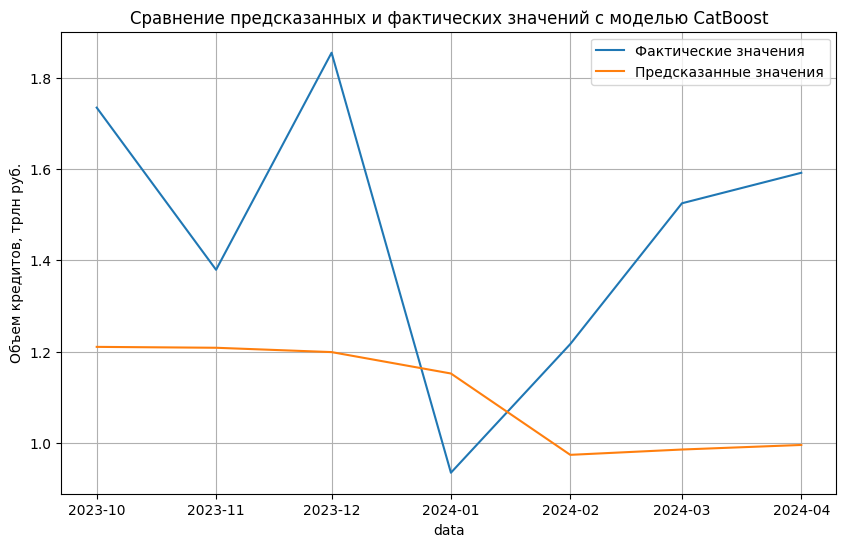

In [34]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(test['data'], Ytest.values/ 1e6, label='Фактические значения')
plt.plot(test['data'], predictions/ 1e6, label='Предсказанные значения')
plt.xlabel('data')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Сравнение предсказанных и фактических значений с моделью CatBoost')
plt.legend()
plt.grid(True)
plt.show()

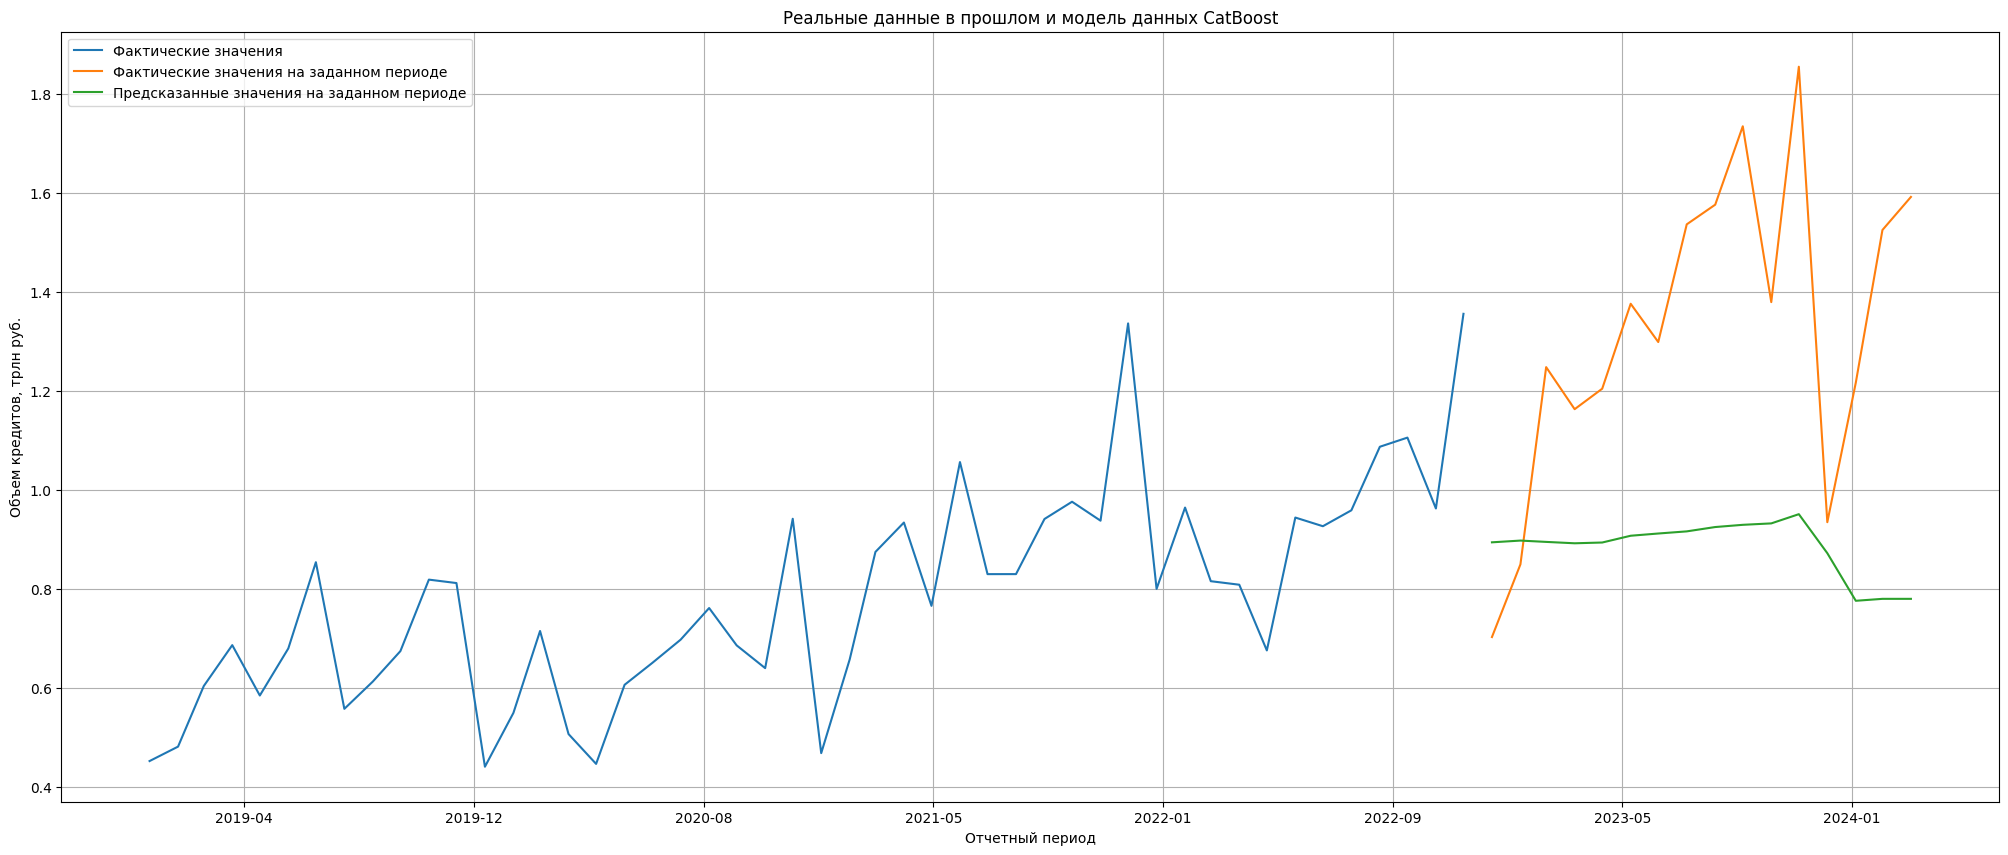

In [21]:
# Построение графика
plt.figure(figsize=(25, 10))
plt.plot(mdates.date2num(trn_val['data']), Y_trn_val.values/ 1e6, label='Фактические значения')
plt.plot(mdates.date2num(test['data']), Ytest.values/ 1e6, label='Фактические значения на заданном периоде')
plt.plot(mdates.date2num(test['data']), predictions/ 1e6, label='Предсказанные значения на заданном периоде')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Реальные данные в прошлом и модель данных CatBoost')
plt.legend()
plt.grid(True)
# Настройка отображения дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # формат даты

plt.show()

Оптимизация гиперпараметров

In [22]:
from sklearn.model_selection import GridSearchCV

# Определение сетки гиперпараметров для перебора
param_grid = {
    'iterations': [50, 100, 200, 500, 1000],
    'depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2]
}

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=CatBoostRegressor(verbose=False), 
                           param_grid=param_grid, 
                           cv=3,  # Количество фолдов для кросс-валидации
                           scoring='neg_mean_squared_error') #метрика для оценки

# Запуск поиска по сетке гиперпараметров
grid_search.fit(Xval, Yval)

# Вывод лучших гиперпараметров
print("Лучшие параметры:", grid_search.best_params_)

# Создание модели с лучшими гиперпараметрами
best_regressor = grid_search.best_estimator_

# Предсказание и оценка на тестовых данных
predictions_opt = best_regressor.predict(Xtest)
predictions_opt

Лучшие параметры: {'depth': 2, 'iterations': 100, 'learning_rate': 0.05}


array([ 759871.22676828,  828116.29612123,  866252.15689847,
        877394.080366  ,  877394.080366  ,  892276.18693   ,
        908563.27441386,  913780.11366798,  913780.11366798,
        899637.5746343 , 1100725.00022101, 1100725.00022101,
        836284.2695773 ,  785484.52614909,  807481.89481384,
        825728.49796921])

In [23]:
mape(Ytest.values, predictions_opt)

30.677772538867792

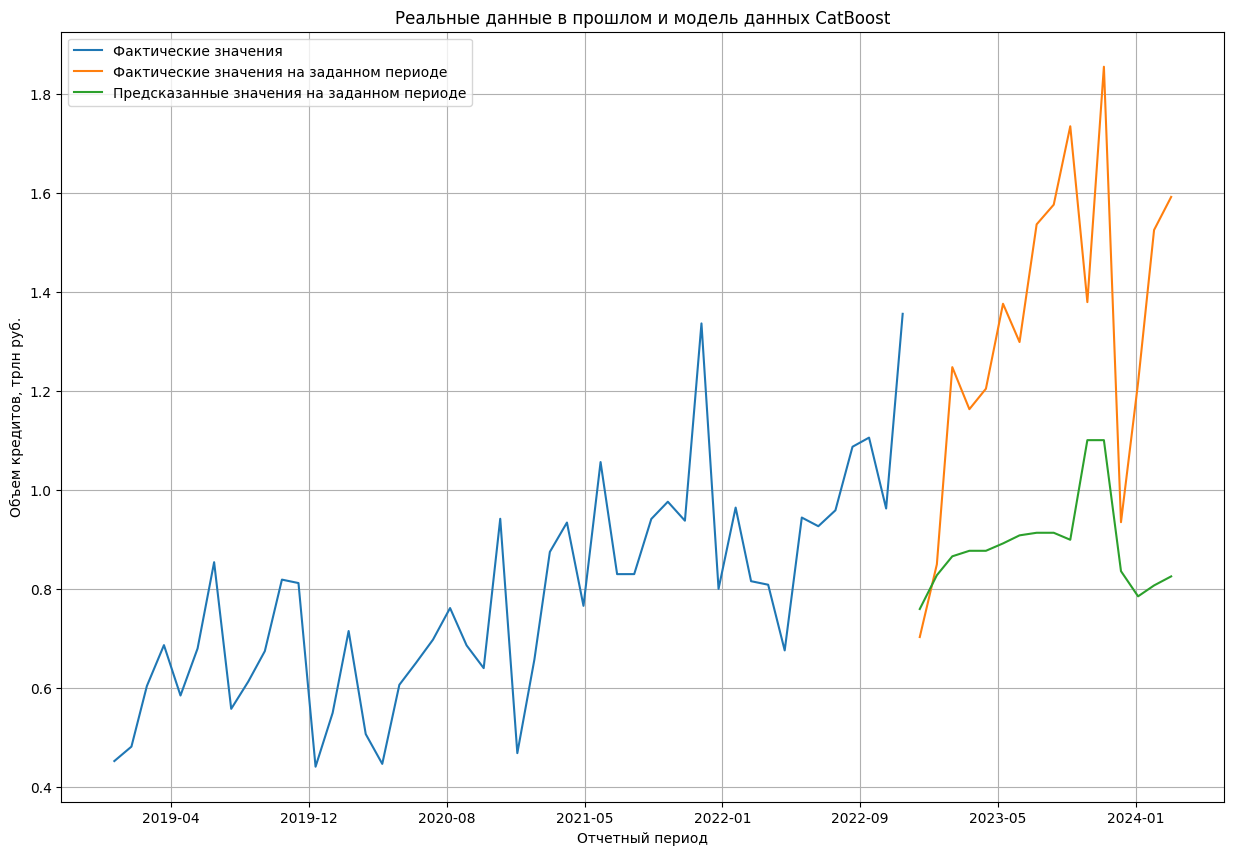

In [24]:
# Построение графика
plt.figure(figsize=(15, 10))
plt.plot(mdates.date2num(trn_val['data']), Y_trn_val.values/ 1e6, label='Фактические значения')
plt.plot(mdates.date2num(test['data']), Ytest.values/ 1e6, label='Фактические значения на заданном периоде')
plt.plot(mdates.date2num(test['data']), predictions_opt/ 1e6, label='Предсказанные значения на заданном периоде')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, трлн руб.')
plt.title('Реальные данные в прошлом и модель данных CatBoost')
plt.legend()
plt.grid(True)
# Настройка отображения дат на оси X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # формат даты

plt.show()

Отбор наилучших признаков

In [32]:
from sklearn.feature_selection import SequentialFeatureSelector

# Создание объекта SequentialFeatureSelector
selector = SequentialFeatureSelector(regressor, 
                                   n_features_to_select='auto',  # Автоматический выбор количества признаков
                                   direction='forward', # Направление отбора: 'forward' (жадный алгоритм), 'backward' (обратный жадный алгоритм)
                                   scoring='neg_mean_squared_error',
                                   cv=3) 

# Обучение селектора на тренировочных данных
selector.fit(Xtrn, Ytrn)

# Получение маски выбранных признаков
selected_features_mask = selector.get_support()

# Вывод названий выбранных признаков
selected_features = Xtrn.columns[selected_features_mask]
print("Выбранные признаки:", selected_features)

# Создание новой модели с выбранными признаками
Xtrn_selected = selector.transform(Xtrn)

best_regressor = CatBoostRegressor(iterations=200, depth=4, learning_rate=0.1)
best_regressor.fit(Xtrn_selected, Ytrn, verbose=False)

# Предсказание на валидационных данных 
predictions_opt_par = best_regressor.predict(Xtest)

0:	learn: 235459.4608521	total: 793us	remaining: 158ms
1:	learn: 235340.5320720	total: 1.26ms	remaining: 125ms
2:	learn: 234945.4804806	total: 1.43ms	remaining: 94.2ms
3:	learn: 234731.0511420	total: 1.59ms	remaining: 77.9ms
4:	learn: 233999.9547696	total: 1.8ms	remaining: 70.4ms
5:	learn: 233833.5921565	total: 1.96ms	remaining: 63.3ms
6:	learn: 233622.2486018	total: 2.15ms	remaining: 59.3ms
7:	learn: 233463.3275851	total: 2.4ms	remaining: 57.7ms
8:	learn: 233132.0841321	total: 2.59ms	remaining: 55ms
9:	learn: 232418.1619217	total: 3.56ms	remaining: 67.6ms
10:	learn: 231983.1733124	total: 3.96ms	remaining: 68.1ms
11:	learn: 231842.3645301	total: 4.21ms	remaining: 65.9ms
12:	learn: 231306.2105993	total: 4.54ms	remaining: 65.3ms
13:	learn: 230777.1288551	total: 4.75ms	remaining: 63.1ms
14:	learn: 230092.7005710	total: 4.92ms	remaining: 60.7ms
15:	learn: 229736.1978542	total: 5.11ms	remaining: 58.7ms
16:	learn: 229537.9164002	total: 5.29ms	remaining: 56.9ms
17:	learn: 229393.4893738	total

In [33]:
mape(Ytest.values, predictions_opt_par)

36.788956425298394

Выполним предсказание до конца 2025 года